In [1]:
!pip install -U --user numpy

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

mxnet 1.7.0.post2 requires numpy<1.17.0,>=1.8.2, but you'll have numpy 1.20.3 which is incompatible.
mxnet 1.7.0.post2 requires requests<2.19.0,>=2.18.4, but you'll have requests 2.24.0 which is incompatible.
tensorflow 2.4.1 requires numpy~=1.19.2, but you'll have numpy 1.20.3 which is incompatible.


In [2]:
!pip install wget

Processing c:\users\jikim\appdata\local\pip\cache\wheels\bd\a8\c3\3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0\wget-3.2-py3-none-any.whl


In [3]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import urllib
import wget

MAX_LEN = 512
EPOCHS = 3
VERBOSE = 2
BATCH_SIZE = 16

In [4]:
DATA_OUT_PATH = './data_out/KOR'

In [5]:
def plot_graphs(history, string, string_1, string_2):
    # loss 
    plt.plot(history.history[string])
    plt.plot(history.history[string_1])
    plt.plot(history.history[string_2])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, string_1, string_2])
    plt.show()

In [6]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)

In [7]:
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", lowercase=False)
save_path = "bert-base-multilingual-cased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert-base-multilingual-cased/vocab.txt", lowercase=False)

In [8]:
train_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_train.json"
train_path = keras.utils.get_file("train.json", train_data_url)
eval_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url)

3883008/3881058 [==============================] - 1s 0us/step


In [9]:
wget.download('https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json', out='./bert-base-multilingual-cased/')

100% [..................................................................................] 625 / 625

'./bert-base-multilingual-cased//bert-base-multilingual-cased-config.json'

In [10]:
os.rename('./bert-base-multilingual-cased/bert-base-multilingual-cased-config.json', './bert-base-multilingual-cased/config.json')

In [11]:
wget.download('https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-tf_model.h5', out='./bert-base-multilingual-cased/')

100% [....................................................................] 1083389348 / 1083389348

'./bert-base-multilingual-cased//bert-base-multilingual-cased-tf_model.h5'

In [12]:
os.rename('./bert-base-multilingual-cased/bert-base-multilingual-cased-tf_model.h5', './bert-base-multilingual-cased/tf_model.h5')

In [13]:
class SquadExample:
    def __init__(self, question, context, start_char_idx, answer_text):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer_text = answer_text
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer_text
        start_char_idx = self.start_char_idx

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        # Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer)
        if end_char_idx >= len(context):
            self.skip = True
            return

        # Mark the character indexes in context that are in answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1

        # Tokenize context
        tokenized_context = tokenizer.encode(context)

        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, (start, end) in enumerate(tokenized_context.offsets):
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        if len(ans_token_idx) == 0:
            self.skip = True
            return

        # Find start and end token index for tokens from answer
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]

        # Tokenize question
        tokenized_question = tokenizer.encode(question)

        # Create inputs
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
            tokenized_question.ids[1:]
        )
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = MAX_LEN - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context.offsets


def create_squad_examples(raw_data):
    squad_examples = []
    for item in raw_data["data"]:
        for para in item["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                question = qa["question"]
                answer_text = qa["answers"][0]["text"]
                start_char_idx = qa["answers"][0]["answer_start"]
                squad_eg = SquadExample(
                    question, context, start_char_idx, answer_text
                )
                squad_eg.preprocess()
                squad_examples.append(squad_eg)
    return squad_examples


def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y


In [14]:
with open(train_path) as f:
    raw_train_data = json.load(f)

with open(eval_path) as f:
    raw_eval_data = json.load(f)


train_squad_examples = create_squad_examples(raw_train_data)
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")

eval_squad_examples = create_squad_examples(raw_eval_data)
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")

60407 training points created.
5774 evaluation points created.


In [15]:
class TFBERTQuestionAnswering(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBERTQuestionAnswering, self).__init__()
        
        self.encoder = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.start_logit = tf.keras.layers.Dense(num_class, name="start_logit", use_bias=False)
        self.end_logit = tf.keras.layers.Dense(num_class, name="end_logit", use_bias=False)
        self.flatten = tf.keras.layers.Flatten() 
        self.softmax = tf.keras.layers.Activation(tf.keras.activations.softmax)
        
    def call(self, inputs):
        input_ids, token_type_ids, attention_mask = inputs
        embedding = self.encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
        start_logits = self.start_logit(embedding)
        start_logits = self.flatten(start_logits)
        
        end_logits = self.end_logit(embedding)
        end_logits = self.flatten(end_logits)
        
        start_probs = self.softmax(start_logits)
        end_probs = self.softmax(end_logits)
    
        return start_probs, end_probs

In [16]:
korquad_model = TFBERTQuestionAnswering(model_name='./bert-base-multilingual-cased/',dir_path='bert_ckpt', num_class=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

Some layers from the model checkpoint at ./bert-base-multilingual-cased/ were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at ./bert-base-multilingual-cased/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [17]:
def normalized_answer(s):    
    def remove_(text):
        ''' 불필요한 기호 제거 '''
        text = re.sub("'", " ", text)
        text = re.sub('"', " ", text)
        text = re.sub('《', " ", text)
        text = re.sub('》', " ", text)
        text = re.sub('<', " ", text)
        text = re.sub('>', " ", text) 
        text = re.sub('〈', " ", text)
        text = re.sub('〉', " ", text)   
        text = re.sub("\(", " ", text)
        text = re.sub("\)", " ", text)
        text = re.sub("‘", " ", text)
        text = re.sub("’", " ", text)      
        return text

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_punc(lower(remove_(s))))

In [18]:
class ExactMatch(keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0
        eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            squad_eg = eval_examples_no_skip[idx]
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start)
            end = np.argmax(end)
            if start >= len(offsets):
                continue
            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]

            normalized_pred_ans = normalized_answer(pred_ans)
            normalized_true_ans = normalized_answer(squad_eg.answer_text)
            if normalized_pred_ans in normalized_true_ans:
                count += 1
        acc = count / len(self.y_eval[0])
        print(f"\nepoch={epoch+1}, exact match score={acc:.2f}")

In [19]:
exact_match_callback = ExactMatch(x_eval, y_eval)

In [20]:
korquad_model.compile(optimizer=optimizer, loss=[loss, loss])

In [21]:
model_name = "tf2_bert_korquad"

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

./data_out/KOR\tf2_bert_korquad -- Folder already exists 



In [ ]:
history = korquad_model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,  # For demonstration, 3 epochs are recommended
    verbose=VERBOSE,
    batch_size=BATCH_SIZE,
    callbacks=[exact_match_callback, cp_callback]
)

In [56]:
print(history.history)

{'loss': [1.6143461465835571, 1.0654442310333252, 0.8548064231872559], 'output_1_loss': [0.7423694133758545, 0.483425110578537, 0.3809109330177307], 'output_2_loss': [0.8719780445098877, 0.5820195078849792, 0.4738943576812744]}


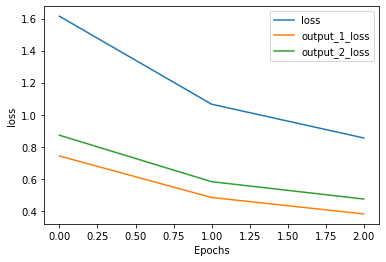

In [57]:
plot_graphs(history, 'loss', 'output_1_loss', 'output_2_loss')

In [58]:
korquad_model.save_weights('data_out/KOR/tf2_bert_korquad/weights_KorQuAD.h5')

In [23]:
korquad_model.load_weights('data_out/KOR/tf2_bert_korquad/weights_KorQuAD.h5')

In [24]:
korquad_model.loss

ListWrapper([<tensorflow.python.keras.losses.SparseCategoricalCrossentropy object at 0x00000291A4AE0520>, <tensorflow.python.keras.losses.SparseCategoricalCrossentropy object at 0x00000291A4AE0520>])

In [ ]:
plot_graphs(korquad_model.history,'loss', 'output_1_loss', 'output_2_loss')

### 모델 predict 구현

In [26]:
korquad_model.load_weights('data_out/KOR/tf2_bert_korquad/weights_KorQuAD.h5')

#### 지문 찾아보기

In [27]:
print(tokenizer.decode(x_eval[0][1]))

1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의 ( 폭력행위등처벌에관한법률위반 ) 으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일 ~ 20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다. 1989년 6월 30일 평양축전에 대표로 파견 된 인물은?


In [28]:
print(x_eval[1][1])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [29]:
tokenized_context= tokenizer.encode("1989년 6월 30일 평양축전에 대표로 파견 된 인물은?")

In [30]:
context_token_to_char = tokenized_context.offsets
print(context_token_to_char)

[(0, 0), (0, 5), (6, 8), (9, 12), (13, 14), (14, 15), (15, 16), (16, 18), (19, 20), (20, 21), (21, 22), (23, 24), (24, 25), (26, 27), (28, 29), (29, 30), (30, 31), (31, 32), (0, 0)]


In [54]:
for i in range(19):
    print(tokenizer.decode([tokenized_context.ids[i]]), end=" ")

 1989년 6월 30일 평 ##양 ##축 ##전에 대 ##표 ##로 파 ##견 된 인 ##물 ##은 ?  

In [56]:
class SquadExample_pred:
    def __init__(self, question, context):#, start_char_idx, answer_text):
        self.question = question
        self.context = context
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        #answer_text = self.answer_text
        #start_char_idx = self.start_char_idx

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())

        # Tokenize context
        tokenized_context = tokenizer.encode(context)
#         print("tokenized_context.ids=", tokenized_context.ids)
#         print("tokenized_context.ids.len=", len(tokenized_context.ids))

        # Tokenize question
        tokenized_question = tokenizer.encode(question)
#         print("tokenized_question.ids=", tokenized_question.ids)

        # Create inputs
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
            tokenized_question.ids[1:]
        )
        
        attention_mask = [1] * len(input_ids)
        

        # Pad and create attention masks.
        # Skip if truncation is needed
        
        padding_length = MAX_LEN - len(input_ids)
        print("padding_length=",padding_length)
        
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return
        
#         print("input_ids=", input_ids)
#         print("token_type_ids=", token_type_ids)
#         print("attention_mask=", attention_mask)

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.context_token_to_char = tokenized_context.offsets
#         print(self.context_token_to_char)
        
    def get_input_target(self):
        dataset_dict = {
            "input_ids": [],
            "token_type_ids": [],
            "attention_mask": [],
        }
        if self.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(self, key))
        for key in dataset_dict:
            dataset_dict[key] = np.array(dataset_dict[key])

        x = [
            dataset_dict["input_ids"],
            dataset_dict["token_type_ids"],
            dataset_dict["attention_mask"],
        ]
#         print(x)
        return x

def create_squad_examples_from_arg(question, context):#, start_char_idx, answer_text):
    squad_eg = SquadExample_pred(
        question, context#, start_char_idx, answer_text
    )
    squad_eg.preprocess()
    return squad_eg


def predict_test(model, pred_raw):
    x_pred = pred_raw.get_input_target()
    pred_start, pred_end = model.predict(x_pred)
    
    pred_start_offset_index = np.argmax(pred_start)
    pred_end_offset_index = np.argmax(pred_end)
    pred_start_offset = pred_raw.context_token_to_char[pred_start_offset_index]
    pred_end_offset = pred_raw.context_token_to_char[pred_end_offset_index]
    answer = pred_context[pred_start_offset[0]:pred_end_offset[1]]
    
    normalized_pred_ans = normalized_answer(answer)
    
    return normalized_pred_ans


pred_context = "해리 케인이 토트넘 홋스퍼 퇴단을 원한다는 보도가 나왔다. 영국 매체 익스프레스는 21일(한국 시간) “케인이 토트넘을 떠나고 싶어 한다. 하지만 다니엘 레비 회장의 거센 반대에 직면할 것”이라고 보도했다. 매체는 유럽 이적시장 전문가인 데이비드 온스테인 기자의 인터뷰 내용을 덧붙였다. 온스테인 기자는 21일 영국 스카이 스포츠에 출연해 “난 축구계에 있는 많은 사람과 얘길 나눈다. 케인이 토트넘을 떠나고 싶어 한단 생각은 일치한다”고 말했다. 케인은 토트넘 유스 출신이다. 밀월 FC, 레스터 시티 등 4번의 임대 생활을 제하면 줄곧 토트넘에서만 뛰었다. 케인은 2014/15시즌부터 주전 공격수로 자리 잡았다. 이후 2차례나 프리미어리그 득점왕을 거머쥐었다. 올 시즌에도 활약은 이어지고 있다. 리그 27경기에 나서 17골 13도움을 기록하며 득점 공동 선두, 도움 1위를 질주 중이다. 개인 성적은 훌륭하지만, 한 가지 아쉬운 게 있다. 우승 트로피가 없단 것. 사실 이번 시즌 토트넘은 리그 제패에 대한 기대가 있었다. 시즌 초 리그 11경기 무패 행진(7승 4무)으로 상위권을 유지했다. 하지만 일관성이 부족했다. 이내 고꾸라졌고 현재는 6위에 있다. 현실적인 목표는 유럽축구연맹(UEFA) 챔피언스리그 티켓을 거머쥐는 것이다. 우승 가능성이 있었던 FA컵, UEFA 유로파리그도 떨어졌다. 남은 대회는 카라바오컵이다. 하지만 이마저도 맨체스터 시티와 결승전을 치른다. 우승을 장담할 수 없다. 결국 우승 트로피 때문에 토트넘을 떠나고 싶어 하는 것으로 보인다.  "
# pred_question = "반대하는 사람?"
pred_question = "유럽 이적시장 전문가?"

pred_data = create_squad_examples_from_arg(pred_question, pred_context)
pred_answer = predict_test(korquad_model, pred_data)
print(pred_answer)

padding_length= 37
데이비드 온스테인


In [58]:
pred_context = "1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의 ( 폭력행위등처벌에관한법률위반 ) 으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일 ~ 20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다."
# pred_question = "1989년 6월 30일 평양축전에 대표로 파견 된 인물은?"
pred_question = "임종석의 사전구속영장을 발부받은 날짜는?"
pred_data = create_squad_examples_from_arg(pred_question, pred_context)
pred_answer = predict_test(korquad_model, pred_data)
print(pred_answer)

padding_length= 202
1989년 3월 12일
